In [1]:
from stock_utils import *

In [325]:
df = pd.DataFrame()
df = df.from_csv('stock_data/spy.csv')
df = df.sort_index(axis=0)

daily_movements = get_price_movement_percentages(df)

In [306]:
def get_close_price(df):
    """ Get the simple moving average of a stock that's in a data frame. """
    df = df.sort_index(axis=0) ## We want the dates in ascending order
    close = np.zeros(len(df))

    for i in range(len(df)):
        close[i] = df['close'][i]

    return close

In [307]:
def get_sma(df, period_length):
    """ Get the simple moving average of a stock that's in a data frame. """
    #df = df.sort_index(axis=0) ## We want the dates in ascending order
    sma = np.zeros(len(df))
    sum_period = np.zeros(len(df))
    count = 0

    for i in range(len(df)):
        count = 0
        for j in range(period_length):
            if (i - j) >= 0:
                sum_period[i] += df[i - j]
                count += 1
        sma[i] = sum_period[i] / count
    return sma

In [326]:
close = get_close_price(df)
sma_20 = get_sma(df['close'], 20)
sma_50 = get_sma(df['close'], 50)
sma_100 = get_sma(df['close'], 100)

In [309]:
g = get_sma(df['close'], 4)
assert(int(g[0]) == int(df['close'][0]))
assert(int(g[1]) == int((df['close'][0] + df['close'][1]) / 2))
assert(int(g[2]) == int((df['close'][0] + df['close'][1] + df['close'][2]) / 3))
assert(int(g[3]) == int((df['close'][0] + df['close'][1] + df['close'][2] + df['close'][3]) / 4))
assert(int(g[4]) == int((df['close'][1] + df['close'][2] + df['close'][3] + df['close'][4]) / 4))

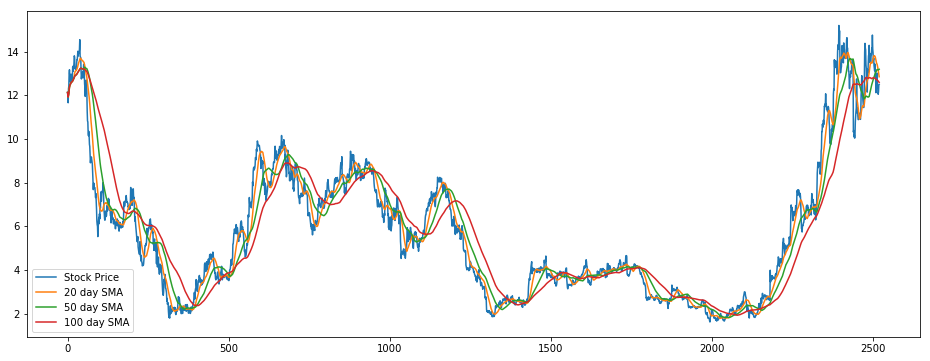

In [310]:
plt.figure(figsize=(16,6))
plt.plot(close, label='Stock Price')
plt.plot(sma_20, label='20 day SMA')
plt.plot(sma_50, label='50 day SMA')
plt.plot(sma_100, label='100 day SMA')
plt.legend()
plt.show()

In [311]:
def get_ema(df, period_length, alpha):
    """ Get the explonential moving average of a stock that's in a data frame. """
    #df = df.sort_index(axis=0) ## We want the dates in ascending order
    ema = np.zeros(len(df))
    sum_period = np.zeros(len(df))
    count = 0
    if not ( 0 <= alpha <= 1):
        raise ValueError('Alpha should be between 0 and 1')

    for i in range(len(df)):
        count = 0
        this_alpha = alpha
        for j in range(period_length):
            if (i - j) >= 0:
                sum_period[i] += df[i - j] * this_alpha
                count += this_alpha
                #print(this_alpha / alpha)
                this_alpha *= alpha
        ema[i] = sum_period[i] / count
    return ema

In [312]:
h = get_ema(df['close'], 4, 1)

In [313]:
assert(int(g[0]) == int(h[0]))
assert(int(g[1]) == int(h[1]))

In [314]:
alpha = 0.95
close = get_close_price(df)
ema_20 = get_ema(close, 20, alpha)
ema_50 = get_ema(close, 50, alpha)
ema_100 = get_ema(close, 100, alpha)

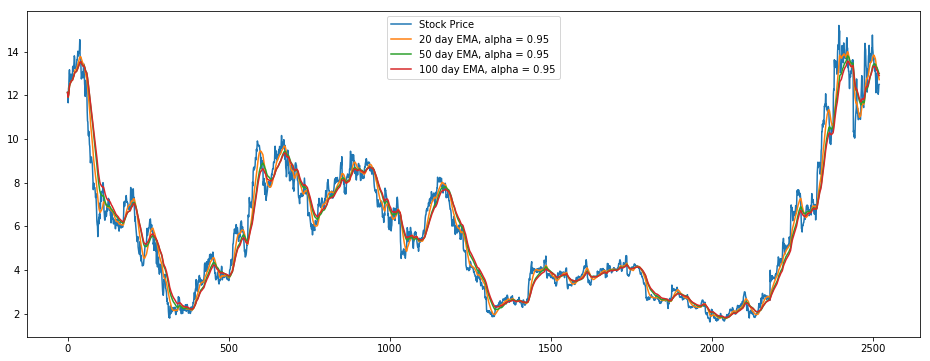

In [315]:
plt.figure(figsize=(16,6))
plt.plot(close, label='Stock Price')
plt.plot(ema_20, label='20 day EMA, alpha = ' + str(alpha))
plt.plot(ema_50, label='50 day EMA, alpha = ' + str(alpha))
plt.plot(ema_100, label='100 day EMA, alpha = ' + str(alpha))
plt.legend()
plt.show()

In [316]:
h[0]

12.130000000000001

In [317]:
g[0]

12.130000000000001

In [318]:
h[2]

11.923333333333334

In [319]:
g[2]

11.923333333333334

In [320]:
h[-1]

12.300000000000001

In [321]:
g[-1]

12.300000000000001

## MACD

In [328]:
alpha = 0.95
ema_12 = get_ema(close, 12, alpha)
ema_26 = get_ema(close, 26, alpha)
macd = ema_12 - ema_26
macd_ema9 = get_ema(macd, 9, alpha)
macd_diff = macd - macd_ema9

zero_line = np.zeros(len(macd))

In [329]:
crossover = np.zeros(len(macd))
for i in range(len(macd)):
    if np.absolute(ema_12[i] - ema_26[i]) < 2:
        crossover[i] = ema_12[i]

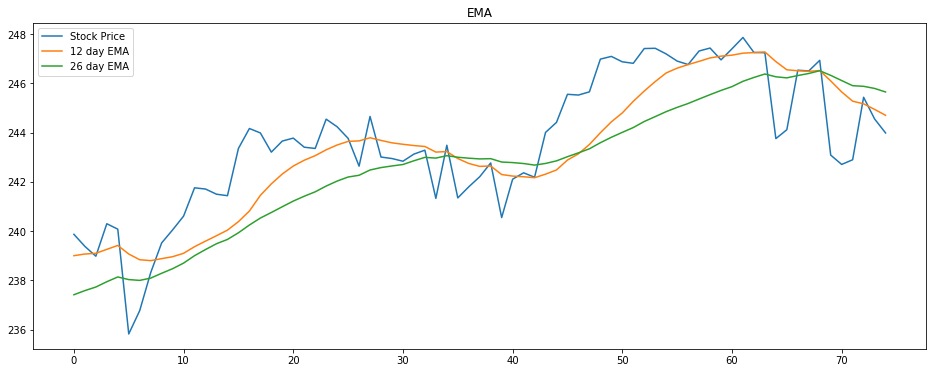

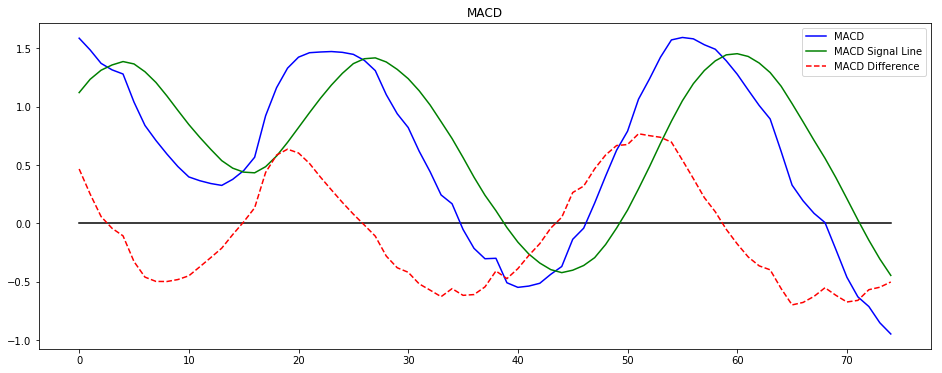

In [330]:
## EMA
plt.figure(figsize=(16,6))
plt.plot(close[-75:], label='Stock Price')
plt.plot(ema_12[-75:], label='12 day EMA')
plt.plot(ema_26[-75:], label='26 day EMA')
#plt.plot(crossover[-200:], label='C')
plt.title('EMA')
plt.legend()

## MACD
plt.figure(figsize=(16,6))
plt.plot(zero_line[-75:], c='black')
plt.plot(macd[-75:], label='MACD', c='blue')
plt.plot(macd_ema9[-75:], label='MACD Signal Line', c='green')
plt.plot(macd_diff[-75:], label='MACD Difference', c='red', linestyle='dashed')
plt.title('MACD')
plt.legend()
plt.show()

## Can use derivative and second derivative of the Difference line as well